In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Visualization of brushfire grid, GVD, and paths
def plot_GVD(grid, GVD=None, path=None):
  fig, ax = plt.subplots()
  GVD_grid = np.copy(grid)
  if GVD:
    GVD_x, GVD_y = zip(*GVD)
    GVD_grid[GVD_x,GVD_y] = 20

  img1 = ax.imshow(GVD_grid, cmap="RdBu", alpha=0.6)
  obstacles = GVD_grid.copy()
  obstacles[obstacles < 0] = -2.0
  masked_data = np.ma.masked_where(obstacles > 0, obstacles)
  img2 = ax.imshow(masked_data, cmap="bwr")
  legend_elements = [Patch(facecolor='blue', label='Obstacle')]
  if GVD: legend_elements.append(Patch(facecolor='#83b1d3', label='GVD'))
  # if GVD: legend_elements.append(Patch(facecolor='yellow', label='GVD'))

  if path:
    path_x, path_y = zip(*path)
    GVD_grid[path_x,path_y] = 40.0
    grid_path = GVD_grid.copy()
    grid_path = np.ma.masked_where(grid_path != 40.0, grid_path)
    img3 = ax.imshow(grid_path, cmap="cool_r", interpolation="nearest") 
    legend_elements.append(Patch(facecolor='#e741f6', label='path'))

  ax.legend(handles=legend_elements)
  plt.show()

In [2]:
# Generation of example environments
# Feel free to generate more using these as baseline

def generate_world_1(width=100, height=100):  
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)  

  grid_world = np.zeros((width, height))
  grid_world = create_rectangle_obstacle(grid_world, 30, 70, 40, 60, -1)

  return grid_world, x_list, y_list


def generate_world_2(width=100, height=100):    
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  
  grid_world = np.zeros((width, height))  
  grid_world = create_rectangle_obstacle(grid_world, 20, 40, 45, 85, -1)
  
  # triangle obstacle
  for x in range(60, 91):
    for y in range(20, 91-x+21):
      grid_world[int(x), int(y)] = -2

  return grid_world, x_list, y_list


def generate_world_3(width=100, height=100):   
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  
  grid_world = np.zeros((width, height))
  grid_world = create_rectangle_obstacle(grid_world, 15, 45, 20, 50, -1)
  grid_world = create_circle_obstacle(grid_world, 75.0, 30.0, 12, -2)
  grid_world = create_circle_obstacle(grid_world, 50.0, 75.0, 16, -3)
  
  return grid_world, x_list, y_list


def generate_world_4(width=100, height=100):   
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  grid_world = np.zeros((width, height))

  # triangle obstacle
  for x in range(50, 81):
    for y in range(20, 21+x-50):
      grid_world[int(x), int(y)] = -1

  grid_world = create_rectangle_obstacle(grid_world, 30, 60, 55, 85, -2)
  grid_world = create_circle_obstacle(grid_world, 25.0, 30.0, 12, -3)
  
  return grid_world, x_list, y_list


def create_circle_obstacle(grid_world, center_x, center_y, radius, obst_id):
  c_x, c_y, r_2 = center_x, center_y, radius
  for x in range(grid_world.shape[0]):
    for y in range(grid_world.shape[1]):
      if np.sqrt((x - c_x)**2 + (y - c_y)**2) < r_2:
        grid_world[int(x), int(y)] = obst_id
  return grid_world


def create_rectangle_obstacle(grid_world, lower_x, upper_x, lower_y, upper_y, obst_id):
  grid_world[lower_x: upper_x, lower_y: upper_y] = obst_id
  return grid_world

In [3]:
z_1, _, _ = generate_world_1()
z_2, _, _ = generate_world_2()
z_3, _, _ = generate_world_3()
z_4, _, _ = generate_world_4()

In [5]:
# Utility functions: You may use or modify any of these

# Return valid neighbors on the grid of cell [i,j]
def neighbors(grid, i, j):
  n = []

  if i-1 >= 0:
    n.append((i-1,j))
    if j-1 >= 0: n.append((i-1,j-1))
    if j+1 < grid.shape[1]: n.append((i-1,j+1))
  if i+1 < grid.shape[0]: 
    n.append((i+1,j))
    if j-1 >= 0: n.append((i+1,j-1))
    if j+1 < grid.shape[1]: n.append((i+1,j+1))
  if j-1 >= 0: n.append((i,j-1))
  if j+1 < grid.shape[1]: n.append((i,j+1))

  return n


# Shortest path from any cell in env to a cell in GVD via gradient ascent
def path_to_GVD(grid, GVD, cell):
  while path[-1] not in GVD:
    next = path[-1]
    for n in neighbors(grid, path[-1][0], path[-1][1]):
      if grid[n[0], n[1]] > grid[next[0], next[1]]:
        next = n
    path.append(next)
  return path


# Shortest path between two points on GVD
def GVD_path(grid, GVD, A, B):
  GVD = set(GVD)
  closed = set([])
  open = [A]
  pointers = {}

  while len(open) > 0:
    cell = open.pop(0)
    new_neighbors = GVD.intersection(set(neighbors(grid, cell[0], cell[1]))) - closed

    if B in new_neighbors:
      pointers[B] = cell
      path = [B]
      while path[-1] != A:
        next = pointers[path[-1]]
        path.append(next)
      return list(reversed(path))

    open += list(new_neighbors)
    closed.update(new_neighbors)
    pointers.update(dict.fromkeys(list(new_neighbors), cell))

  return None

In [6]:
def check_if_no_zeros_left(grid):
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i, j] == 0:
                return 0
            else:
                pass
    return 1

In [7]:
def apply_brushfire_algo(grid):
    GVD_grid = []
    grid_pointer = np.empty((len(grid), len(grid[0])))
    for i in range(len(grid_pointer)):
      for j in range(len(grid_pointer)):
        grid_pointer[i,j] = None
    #create boundary first
    for i in range(len(grid[0])):
        if grid[0,i] == 0:
            grid[0,i] = 1
            grid_pointer[0,i] = 1
        if grid[-1,i] == 0:
            grid[-1,i] = 1
            grid_pointer[-1,i] = 2
    for i in range(len(grid)):
        if grid[i,0] == 0:
            grid[i,0] = 1
            grid_pointer[i,0] = 3
        if grid[i,-1] == 0:
            grid[i,-1] = 1
            grid_pointer[i,-1] = 4
    
    #1st wave
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i,j] < 0:
                grid_pointer[i,j]=grid[i,j]
                node_neighbors = neighbors(grid, i, j)
                for k in range(len(node_neighbors)):
                    if grid[node_neighbors[k][0], node_neighbors[k][1]] == 0:
                        grid[node_neighbors[k][0], node_neighbors[k][1]] = 1
                        grid_pointer[node_neighbors[k][0], node_neighbors[k][1]] = grid_pointer[i,j]
                    elif grid[node_neighbors[k][0], node_neighbors[k][1]] == 1:
                            if grid_pointer[node_neighbors[k][0], node_neighbors[k][1]] != grid_pointer[i,j]:
                              if (node_neighbors[k][0], node_neighbors[k][1]) in GVD_grid:
                                pass
                              else:
                                GVD_grid.append((node_neighbors[k][0], node_neighbors[k][1]))

    #2nd wave and there-on
    max_value = 1
    while check_if_no_zeros_left(grid) == 0:
        update_value = 1 + max_value
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if (i,j) in GVD_grid:
                  pass
                else:
                  if grid[i,j] == max_value:
                      node_neighbors = neighbors(grid, i, j)
                      for k in range(len(node_neighbors)):
                          if grid[node_neighbors[k][0], node_neighbors[k][1]] == 0:
                              grid[node_neighbors[k][0], node_neighbors[k][1]] = update_value
                              grid_pointer[node_neighbors[k][0], node_neighbors[k][1]] = grid_pointer[i,j]
                          elif grid[node_neighbors[k][0], node_neighbors[k][1]] == update_value:
                              if grid_pointer[node_neighbors[k][0], node_neighbors[k][1]] != grid_pointer[i,j]:
                                  if (node_neighbors[k][0], node_neighbors[k][1]) in GVD_grid:
                                    pass
                                  else:
                                    GVD_grid.append((node_neighbors[k][0], node_neighbors[k][1]))
                          elif grid[node_neighbors[k][0], node_neighbors[k][1]]==max_value:
                              if grid_pointer[node_neighbors[k][0], node_neighbors[k][1]] != grid_pointer[i,j]:
                                  if (node_neighbors[k][0], node_neighbors[k][1]) in GVD_grid:
                                    pass
                                  else:
                                    GVD_grid.append((node_neighbors[k][0], node_neighbors[k][1]))
                                  if (i, j) in GVD_grid:
                                    pass
                                  else:
                                    GVD_grid.append((i,j))
                                  
        max_value = update_value
    return grid, GVD_grid

In [8]:
def path_finder(grid, gvd, start, goal):
  path_1 = path_to_GVD(grid, gvd, start)
  path_2 = list(reversed(path_to_GVD(grid, gvd, goal)))
  path_mid = GVD_path(grid, gvd, path_1[-1], path_2[0])
  complete_path = path_1.copy()
  complete_path.append(path_mid)
  complete_path.append(path_2)
  
  return complete_path

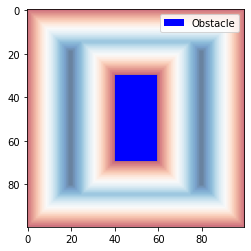

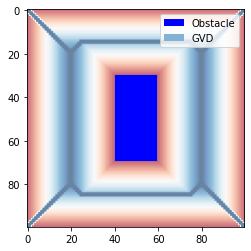

In [9]:
grid = z_1.copy()
GVD_grid = []
grid, GVD_grid = apply_brushfire_algo(grid)
plot_GVD(grid)
plot_GVD(grid, GVD_grid)


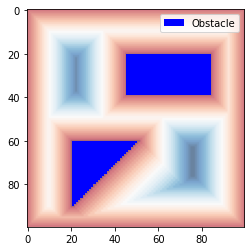

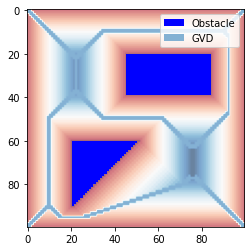

In [10]:
grid = z_2.copy()
GVD_grid = []
grid, GVD_grid = apply_brushfire_algo(grid)
plot_GVD(grid)
plot_GVD(grid, GVD_grid)


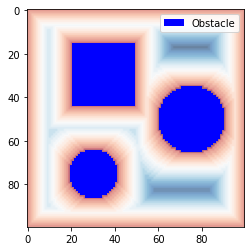

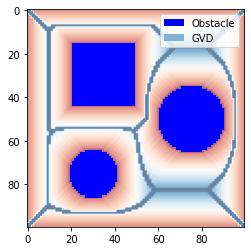

In [11]:
grid = z_3.copy()
GVD_grid = []
grid, GVD_grid = apply_brushfire_algo(grid)
plot_GVD(grid)
plot_GVD(grid, GVD_grid)


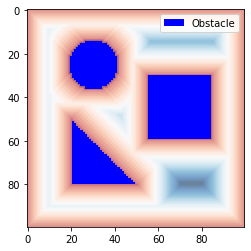

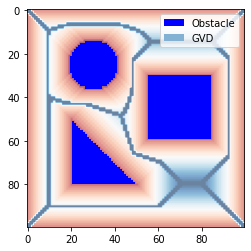

In [12]:
grid = z_4.copy()
GVD_grid = []
grid, GVD_grid = apply_brushfire_algo(grid)
plot_GVD(grid)
plot_GVD(grid, GVD_grid)
